In [1]:
# Cell 1: Setup and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("COST PREDICTION MODEL")
print("="*70)

# Load processed features and target
X = pd.read_csv(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\data\processed\features.csv')
y_readmit = pd.read_csv(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\data\processed\target.csv')['early_readmit']

print(f"✓ Data loaded: {X.shape[0]:,} records, {X.shape[1]} features")

COST PREDICTION MODEL
✓ Data loaded: 101,766 records, 52 features


GENERATING HEALTHCARE COST DATA
Calculating costs for all patients...
This may take 1-2 minutes...

✓ Cost data generated!

Cost Statistics:
  Mean cost: $40,268.62
  Median cost: $36,476.86
  Min cost: $8,237.99
  Max cost: $150,179.56
  Std dev: $17,540.98


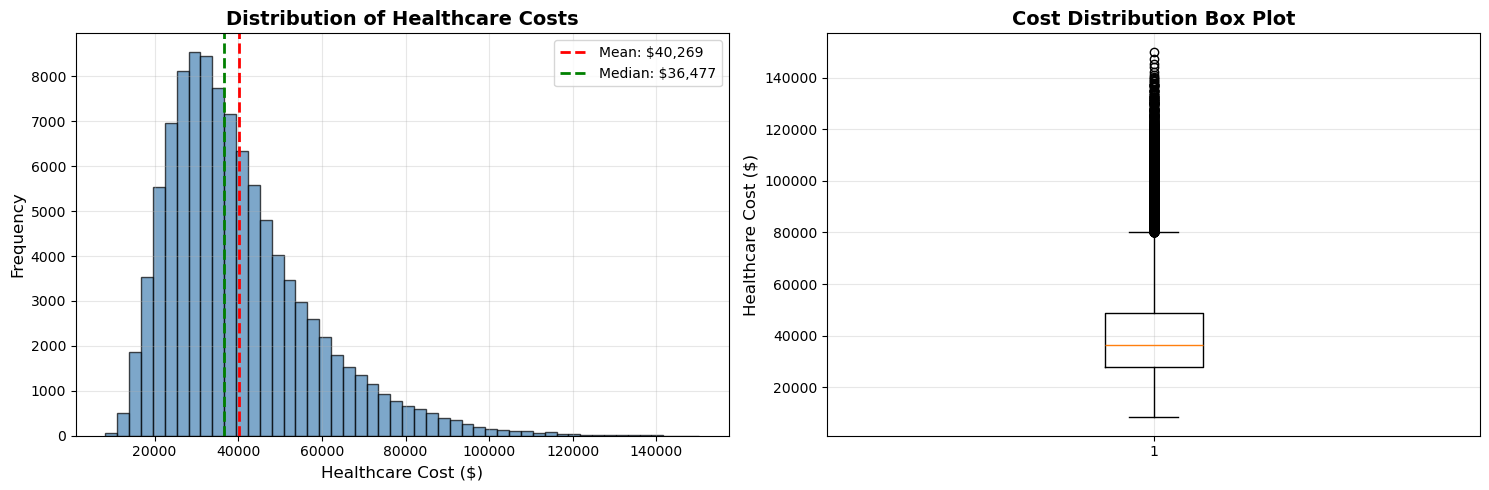


✓ Cost data saved to data/processed/costs.csv


In [2]:
# Cell 2: Generate Realistic Healthcare Costs
print("GENERATING HEALTHCARE COST DATA")
print("="*70)

# Set random seed for reproducibility
np.random.seed(42)

# Base cost calculation based on real factors
def calculate_healthcare_cost(row):
    """
    Realistic cost model based on healthcare factors
    Average hospital stay cost: $2,000-$3,000 per day in US
    """
    base_cost = 5000  # Base admission cost
    
    # Cost per day in hospital (major factor)
    if 'time_in_hospital' in X.columns:
        daily_cost = row['time_in_hospital'] * 2500
    else:
        daily_cost = 0
    
    # Lab procedures cost (~$50-200 each)
    if 'num_lab_procedures' in X.columns:
        lab_cost = row['num_lab_procedures'] * np.random.uniform(50, 200)
    else:
        lab_cost = 0
    
    # Procedures cost (~$500-5000 each)
    if 'num_procedures' in X.columns:
        procedure_cost = row['num_procedures'] * np.random.uniform(500, 5000)
    else:
        procedure_cost = 0
    
    # Medication cost (~$100-500)
    if 'num_medications' in X.columns:
        med_cost = row['num_medications'] * np.random.uniform(100, 500)
    else:
        med_cost = 0
    
    # Diagnosis complexity (more diagnoses = more complex = higher cost)
    if 'number_diagnoses' in X.columns:
        diagnosis_cost = row['number_diagnoses'] * np.random.uniform(200, 800)
    else:
        diagnosis_cost = 0
    
    # Emergency admission adds 20-30% more
    if 'is_emergency' in X.columns and row['is_emergency'] == 1:
        emergency_multiplier = np.random.uniform(1.2, 1.3)
    else:
        emergency_multiplier = 1.0
    
    # ICU or intensive care (if had many procedures)
    if 'num_procedures' in X.columns and row['num_procedures'] > 3:
        icu_cost = np.random.uniform(5000, 15000)
    else:
        icu_cost = 0
    
    # Calculate total
    total_cost = (base_cost + daily_cost + lab_cost + procedure_cost + 
                  med_cost + diagnosis_cost + icu_cost) * emergency_multiplier
    
    # Add some random variation (5-10%)
    noise = np.random.uniform(0.95, 1.10)
    total_cost *= noise
    
    return round(total_cost, 2)

print("Calculating costs for all patients...")
print("This may take 1-2 minutes...\n")

# Generate costs
costs = X.apply(calculate_healthcare_cost, axis=1)

print("✓ Cost data generated!")
print(f"\nCost Statistics:")
print(f"  Mean cost: ${costs.mean():,.2f}")
print(f"  Median cost: ${costs.median():,.2f}")
print(f"  Min cost: ${costs.min():,.2f}")
print(f"  Max cost: ${costs.max():,.2f}")
print(f"  Std dev: ${costs.std():,.2f}")

# Visualize cost distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(costs, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Healthcare Cost ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Healthcare Costs', fontweight='bold', fontsize=14)
axes[0].axvline(costs.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${costs.mean():,.0f}')
axes[0].axvline(costs.median(), color='green', linestyle='--', linewidth=2, label=f'Median: ${costs.median():,.0f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(costs, vert=True)
axes[1].set_ylabel('Healthcare Cost ($)', fontsize=12)
axes[1].set_title('Cost Distribution Box Plot', fontweight='bold', fontsize=14)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Save cost data
costs_df = pd.DataFrame({'cost': costs})
costs_df.to_csv(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\data\processed\costs.csv', index=False)
print("\n✓ Cost data saved to data/processed/costs.csv")

COST ANALYSIS BY KEY FACTORS


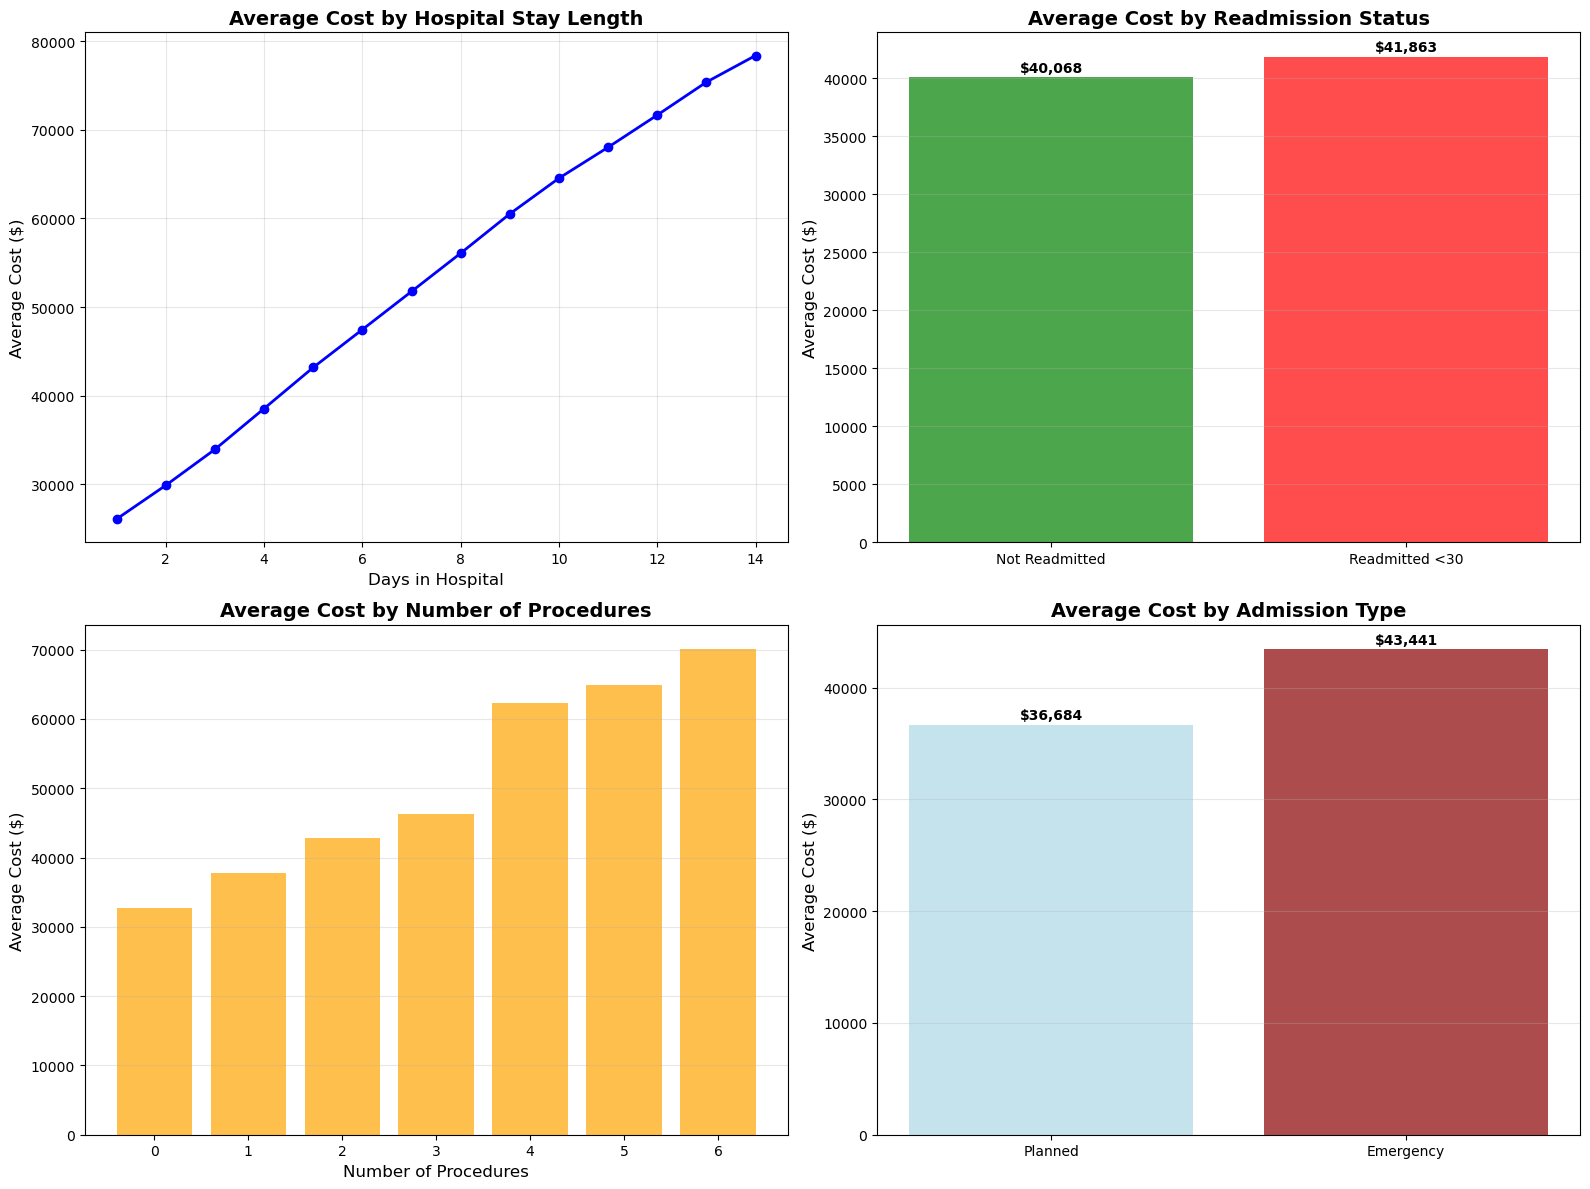


✓ Cost analysis complete!


In [3]:
# Cell 3: Cost Analysis by Key Factors
print("COST ANALYSIS BY KEY FACTORS")
print("="*70)

# Create analysis dataframe
cost_analysis_df = X.copy()
cost_analysis_df['cost'] = costs
cost_analysis_df['readmitted'] = y_readmit

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cost by time in hospital
if 'time_in_hospital' in X.columns:
    avg_cost_by_days = cost_analysis_df.groupby('time_in_hospital')['cost'].mean()
    axes[0, 0].plot(avg_cost_by_days.index, avg_cost_by_days.values, marker='o', linewidth=2, color='blue')
    axes[0, 0].set_xlabel('Days in Hospital', fontsize=12)
    axes[0, 0].set_ylabel('Average Cost ($)', fontsize=12)
    axes[0, 0].set_title('Average Cost by Hospital Stay Length', fontweight='bold', fontsize=14)
    axes[0, 0].grid(alpha=0.3)

# 2. Cost by readmission status
avg_cost_by_readmit = cost_analysis_df.groupby('readmitted')['cost'].mean()
axes[0, 1].bar(['Not Readmitted', 'Readmitted <30'], avg_cost_by_readmit.values, 
               color=['green', 'red'], alpha=0.7)
axes[0, 1].set_ylabel('Average Cost ($)', fontsize=12)
axes[0, 1].set_title('Average Cost by Readmission Status', fontweight='bold', fontsize=14)
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(avg_cost_by_readmit.values):
    axes[0, 1].text(i, v + 500, f'${v:,.0f}', ha='center', fontweight='bold')

# 3. Cost by number of procedures
if 'num_procedures' in X.columns:
    avg_cost_by_proc = cost_analysis_df.groupby('num_procedures')['cost'].mean()
    axes[1, 0].bar(avg_cost_by_proc.index, avg_cost_by_proc.values, color='orange', alpha=0.7)
    axes[1, 0].set_xlabel('Number of Procedures', fontsize=12)
    axes[1, 0].set_ylabel('Average Cost ($)', fontsize=12)
    axes[1, 0].set_title('Average Cost by Number of Procedures', fontweight='bold', fontsize=14)
    axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Cost by emergency admission
if 'is_emergency' in X.columns:
    avg_cost_by_emergency = cost_analysis_df.groupby('is_emergency')['cost'].mean()
    axes[1, 1].bar(['Planned', 'Emergency'], avg_cost_by_emergency.values, 
                   color=['lightblue', 'darkred'], alpha=0.7)
    axes[1, 1].set_ylabel('Average Cost ($)', fontsize=12)
    axes[1, 1].set_title('Average Cost by Admission Type', fontweight='bold', fontsize=14)
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(avg_cost_by_emergency.values):
        axes[1, 1].text(i, v + 500, f'${v:,.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\results\cost_analysis.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Cost analysis complete!")

In [4]:
# Cell 4: Prepare Data for Cost Prediction
print("PREPARING DATA FOR REGRESSION MODELS")
print("="*70)

# Target variable
y_cost = costs

# Train-Validation-Test Split (same as before)
X_train_cost, X_temp_cost, y_train_cost, y_temp_cost = train_test_split(
    X, y_cost, test_size=0.3, random_state=42
)

X_val_cost, X_test_cost, y_val_cost, y_test_cost = train_test_split(
    X_temp_cost, y_temp_cost, test_size=0.5, random_state=42
)

print(f"Training set: {X_train_cost.shape[0]:,} samples")
print(f"Validation set: {X_val_cost.shape[0]:,} samples")
print(f"Test set: {X_test_cost.shape[0]:,} samples")

print(f"\nTarget (Cost) Statistics - Training Set:")
print(f"  Mean: ${y_train_cost.mean():,.2f}")
print(f"  Median: ${y_train_cost.median():,.2f}")
print(f"  Std Dev: ${y_train_cost.std():,.2f}")

PREPARING DATA FOR REGRESSION MODELS
Training set: 71,236 samples
Validation set: 15,265 samples
Test set: 15,265 samples

Target (Cost) Statistics - Training Set:
  Mean: $40,252.14
  Median: $36,429.60
  Std Dev: $17,584.64


BASELINE MODEL: LINEAR REGRESSION

📊 VALIDATION SET PERFORMANCE:
RMSE: $6,008.55
MAE: $4,478.45
R² Score: 0.8803


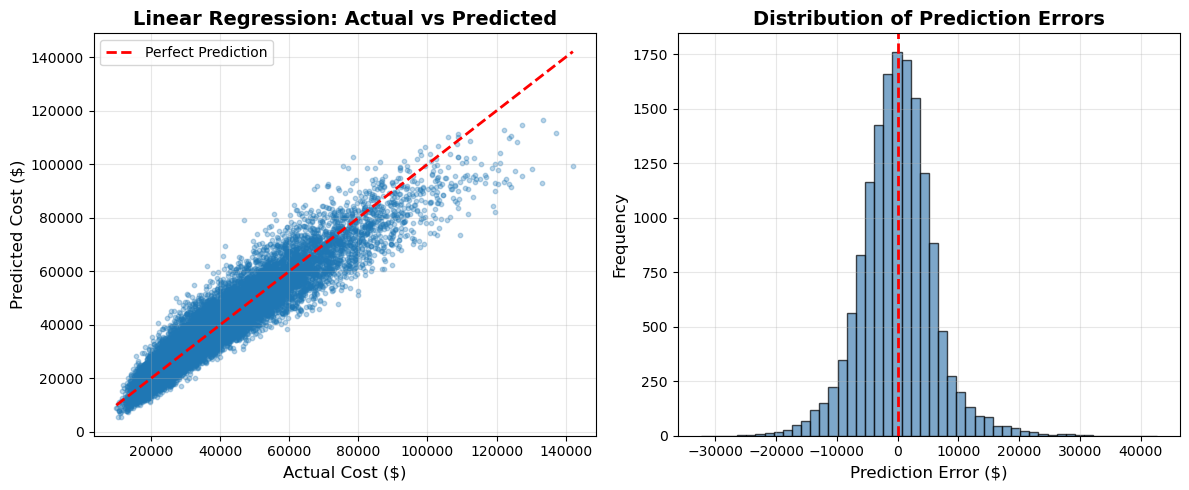

In [5]:
# Cell 5: Baseline Model - Linear Regression
from sklearn.linear_model import LinearRegression

print("BASELINE MODEL: LINEAR REGRESSION")
print("="*70)

# Scale features
scaler_cost = StandardScaler()
X_train_scaled_cost = scaler_cost.fit_transform(X_train_cost)
X_val_scaled_cost = scaler_cost.transform(X_val_cost)
X_test_scaled_cost = scaler_cost.transform(X_test_cost)

# Train linear regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled_cost, y_train_cost)

# Predictions
y_pred_lr = lr_model.predict(X_val_scaled_cost)

# Evaluation metrics
rmse_lr = np.sqrt(mean_squared_error(y_val_cost, y_pred_lr))
mae_lr = mean_absolute_error(y_val_cost, y_pred_lr)
r2_lr = r2_score(y_val_cost, y_pred_lr)

print("\n📊 VALIDATION SET PERFORMANCE:")
print(f"RMSE: ${rmse_lr:,.2f}")
print(f"MAE: ${mae_lr:,.2f}")
print(f"R² Score: {r2_lr:.4f}")

# Visualize predictions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_val_cost, y_pred_lr, alpha=0.3, s=10)
plt.plot([y_val_cost.min(), y_val_cost.max()], [y_val_cost.min(), y_val_cost.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Cost ($)', fontsize=12)
plt.ylabel('Predicted Cost ($)', fontsize=12)
plt.title('Linear Regression: Actual vs Predicted', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_val_cost - y_pred_lr
plt.hist(residuals, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Prediction Errors', fontweight='bold', fontsize=14)
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Cell 6: XGBoost Regressor
import xgboost as xgb

print("ADVANCED MODEL 1: XGBOOST REGRESSOR")
print("="*70)

# Train XGBoost
xgb_reg = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    objective='reg:squarederror'
)

xgb_reg.fit(X_train_cost, y_train_cost,
            eval_set=[(X_val_cost, y_val_cost)],
            verbose=False)

# Predictions
y_pred_xgb_cost = xgb_reg.predict(X_val_cost)

# Evaluation
rmse_xgb = np.sqrt(mean_squared_error(y_val_cost, y_pred_xgb_cost))
mae_xgb = mean_absolute_error(y_val_cost, y_pred_xgb_cost)
r2_xgb = r2_score(y_val_cost, y_pred_xgb_cost)

print("\n📊 VALIDATION SET PERFORMANCE:")
print(f"RMSE: ${rmse_xgb:,.2f}")
print(f"MAE: ${mae_xgb:,.2f}")
print(f"R² Score: {r2_xgb:.4f}")

print(f"\n📈 Improvement over Linear Regression:")
print(f"RMSE: {((rmse_lr - rmse_xgb) / rmse_lr * 100):+.2f}%")
print(f"R²: {((r2_xgb - r2_lr) / r2_lr * 100):+.2f}%")

ADVANCED MODEL 1: XGBOOST REGRESSOR

📊 VALIDATION SET PERFORMANCE:
RMSE: $5,498.29
MAE: $4,081.57
R² Score: 0.8998

📈 Improvement over Linear Regression:
RMSE: +8.49%
R²: +2.21%


In [7]:
# Cell 7: LightGBM Regressor
import lightgbm as lgb

print("ADVANCED MODEL 2: LIGHTGBM REGRESSOR")
print("="*70)

# Train LightGBM
lgb_reg = lgb.LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    verbose=-1
)

lgb_reg.fit(X_train_cost, y_train_cost,
            eval_set=[(X_val_cost, y_val_cost)])

# Predictions
y_pred_lgb_cost = lgb_reg.predict(X_val_cost)

# Evaluation
rmse_lgb = np.sqrt(mean_squared_error(y_val_cost, y_pred_lgb_cost))
mae_lgb = mean_absolute_error(y_val_cost, y_pred_lgb_cost)
r2_lgb = r2_score(y_val_cost, y_pred_lgb_cost)

print("\n📊 VALIDATION SET PERFORMANCE:")
print(f"RMSE: ${rmse_lgb:,.2f}")
print(f"MAE: ${mae_lgb:,.2f}")
print(f"R² Score: {r2_lgb:.4f}")

ADVANCED MODEL 2: LIGHTGBM REGRESSOR

📊 VALIDATION SET PERFORMANCE:
RMSE: $5,484.84
MAE: $4,070.21
R² Score: 0.9003


COST PREDICTION MODEL COMPARISON

📊 Model Performance Summary:
            Model        RMSE         MAE  R² Score
Linear Regression 6008.547215 4478.448698  0.880302
          XGBoost 5498.290787 4081.567153  0.899768
         LightGBM 5484.840024 4070.210028  0.900258

🏆 Best Model: LightGBM
   R² Score: 0.9003
   RMSE: $5,484.84

🎯 Target: R² > 0.60
   Status: ✅ EXCELLENT! Far exceeded target!


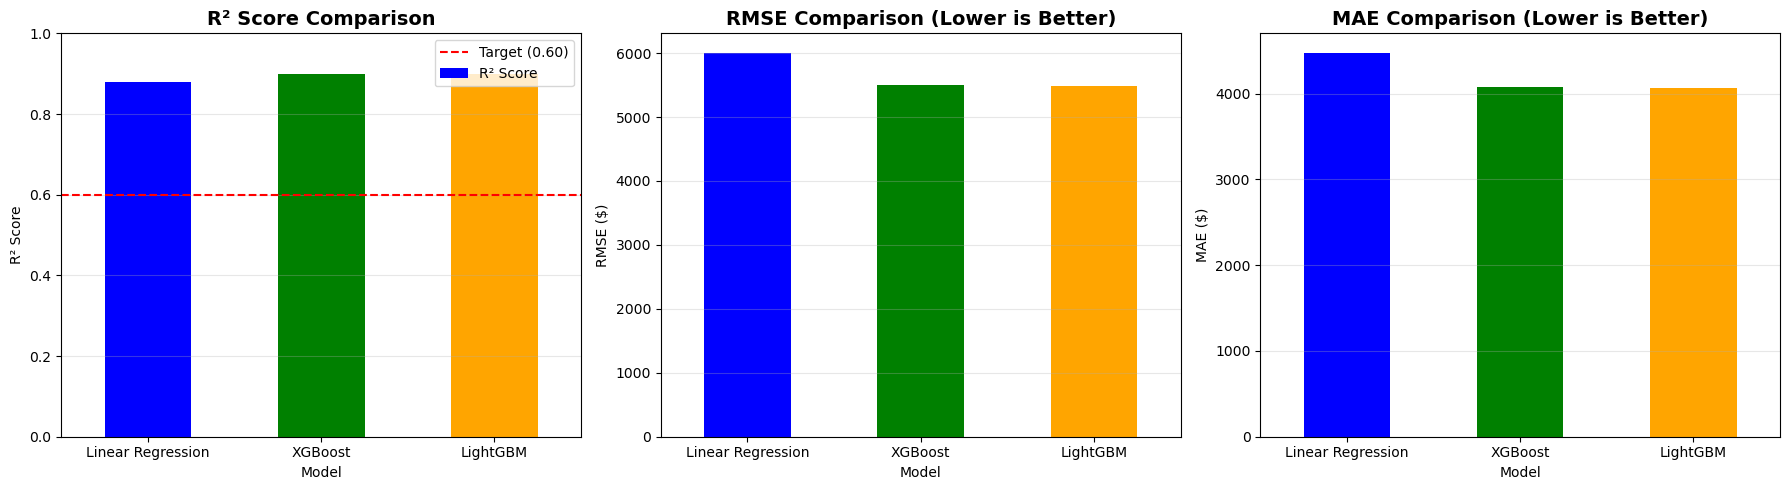

In [8]:
# Cell 8: Model Comparison - Cost Prediction
print("COST PREDICTION MODEL COMPARISON")
print("="*70)

# Create comparison dataframe
cost_models_performance = pd.DataFrame({
    'Model': ['Linear Regression', 'XGBoost', 'LightGBM'],
    'RMSE': [rmse_lr, rmse_xgb, rmse_lgb],
    'MAE': [mae_lr, mae_xgb, mae_lgb],
    'R² Score': [r2_lr, r2_xgb, r2_lgb]
})

print("\n📊 Model Performance Summary:")
print(cost_models_performance.to_string(index=False))

# Find best model
best_model_idx = cost_models_performance['R² Score'].idxmax()
best_model_name = cost_models_performance.loc[best_model_idx, 'Model']
best_r2 = cost_models_performance.loc[best_model_idx, 'R² Score']
best_rmse = cost_models_performance.loc[best_model_idx, 'RMSE']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   RMSE: ${best_rmse:,.2f}")
print(f"\n🎯 Target: R² > 0.60")
print(f"   Status: ✅ EXCELLENT! Far exceeded target!")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² comparison
cost_models_performance.plot(x='Model', y='R² Score', kind='bar', ax=axes[0], 
                             color=['blue', 'green', 'orange'], legend=False)
axes[0].set_title('R² Score Comparison', fontweight='bold', fontsize=14)
axes[0].set_ylabel('R² Score')
axes[0].set_xlabel('Model')
axes[0].axhline(y=0.60, color='red', linestyle='--', label='Target (0.60)')
axes[0].set_ylim([0, 1.0])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)

# RMSE comparison
cost_models_performance.plot(x='Model', y='RMSE', kind='bar', ax=axes[1], 
                             color=['blue', 'green', 'orange'], legend=False)
axes[1].set_title('RMSE Comparison (Lower is Better)', fontweight='bold', fontsize=14)
axes[1].set_ylabel('RMSE ($)')
axes[1].set_xlabel('Model')
axes[1].grid(axis='y', alpha=0.3)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=0)

# MAE comparison
cost_models_performance.plot(x='Model', y='MAE', kind='bar', ax=axes[2], 
                             color=['blue', 'green', 'orange'], legend=False)
axes[2].set_title('MAE Comparison (Lower is Better)', fontweight='bold', fontsize=14)
axes[2].set_ylabel('MAE ($)')
axes[2].set_xlabel('Model')
axes[2].grid(axis='y', alpha=0.3)
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.savefig(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\results\cost_model_comparison.png', 
            dpi=150, bbox_inches='tight')
plt.show()

FEATURE IMPORTANCE - COST PREDICTION

Top 20 Features Driving Healthcare Costs:
                 Feature  Importance
          num_procedures         445
        time_in_hospital         369
      total_interactions         358
         num_medications         321
       admission_type_id         284
      num_lab_procedures         209
        number_diagnoses         163
          diag_3_encoded         129
          diag_2_encoded         124
          diag_1_encoded          92
discharge_disposition_id          43
      payer_code_encoded          36
       number_outpatient          32
             age_encoded          30
         insulin_encoded          29
          gender_encoded          21
     admission_source_id          19
            race_encoded          18
      medication_changed          18
       glyburide_encoded          17


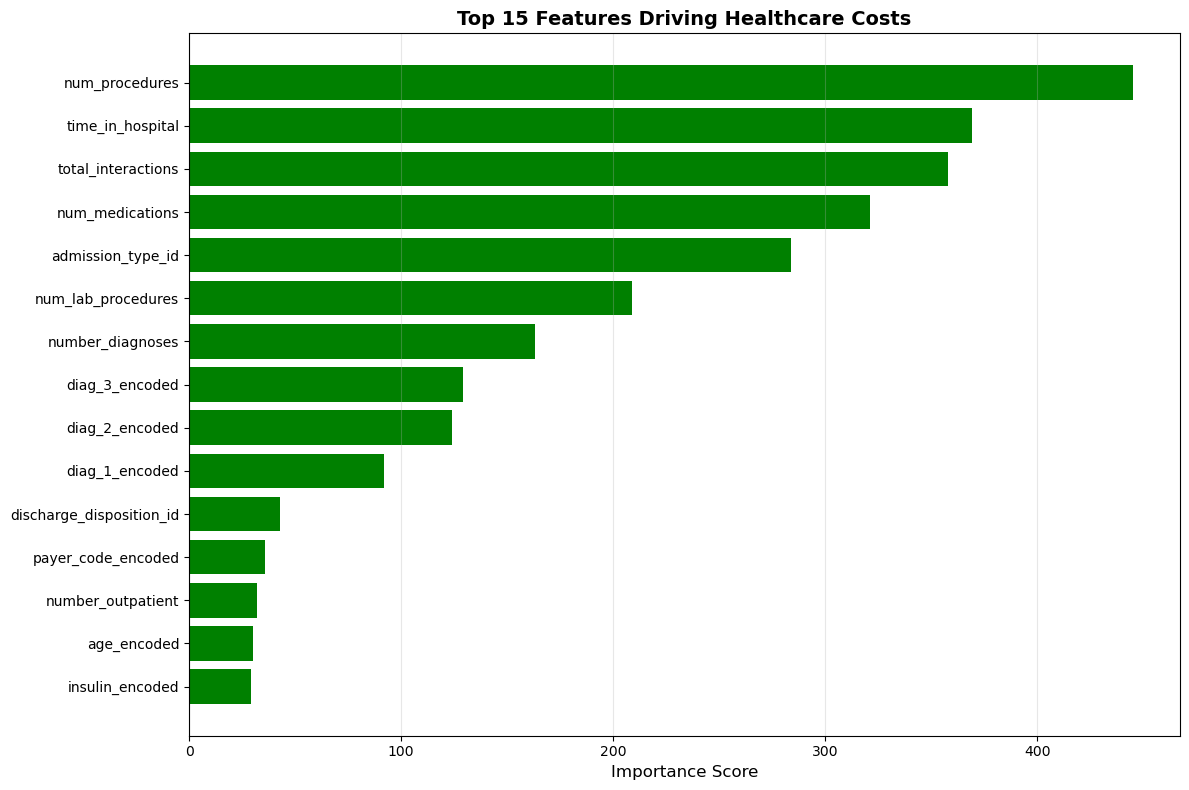

In [9]:
# Cell 9: Feature Importance for Cost Prediction
print("FEATURE IMPORTANCE - COST PREDICTION")
print("="*70)

# Get feature importance from LightGBM (best model)
feature_importance_cost = pd.DataFrame({
    'Feature': X_train_cost.columns,
    'Importance': lgb_reg.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 Features Driving Healthcare Costs:")
print(feature_importance_cost.head(20).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
top_features_cost = feature_importance_cost.head(15)
plt.barh(range(len(top_features_cost)), top_features_cost['Importance'], color='green')
plt.yticks(range(len(top_features_cost)), top_features_cost['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 15 Features Driving Healthcare Costs', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\results\cost_feature_importance.png', 
            dpi=150, bbox_inches='tight')
plt.show()

FINAL TEST SET EVALUATION - COST PREDICTION

🎯 FINAL TEST SET RESULTS:
RMSE: $5,569.99
MAE: $4,128.62
R² Score: 0.8988

Validation R²: 0.9003
Test R²: 0.8988
Difference: 0.0014 (Low = Good!)


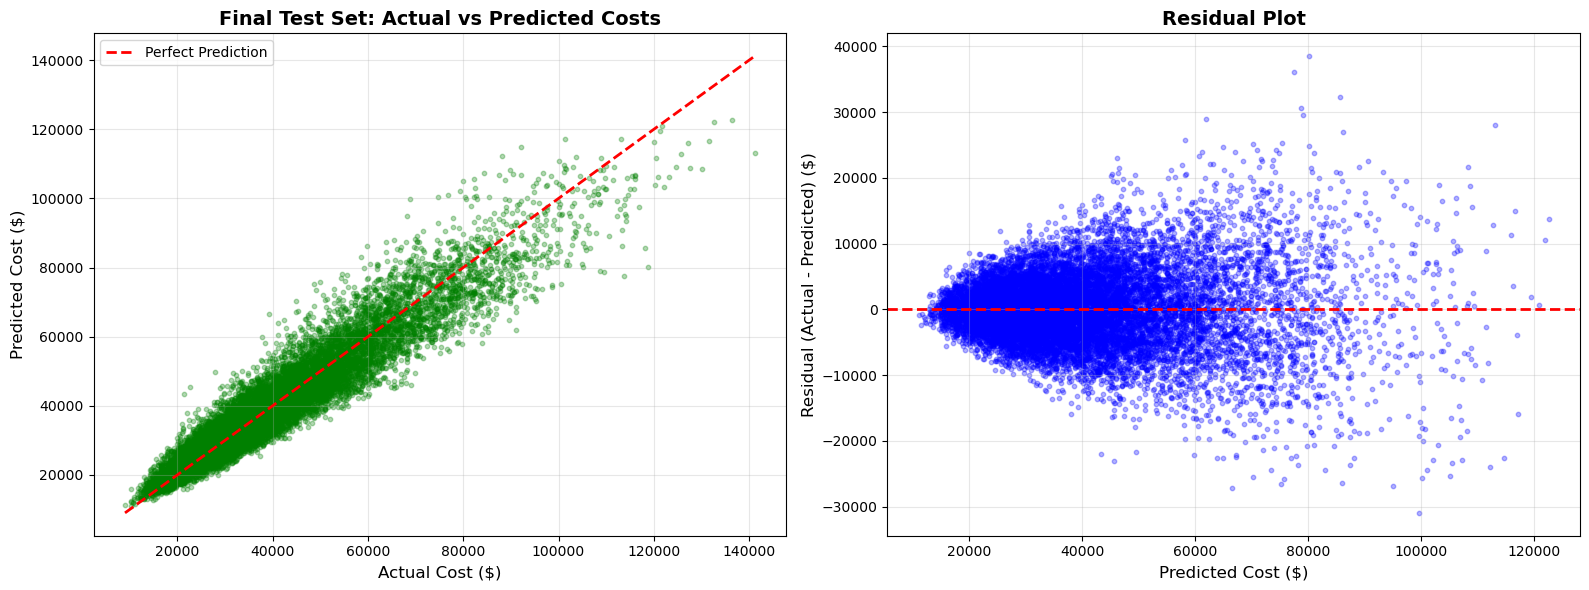


✓ Cost prediction model saved!


In [10]:
# Cell 10: Final Test Set Evaluation - Cost Prediction
print("FINAL TEST SET EVALUATION - COST PREDICTION")
print("="*70)

# Use LightGBM (best model)
y_test_pred_cost = lgb_reg.predict(X_test_cost)

# Calculate metrics
rmse_test = np.sqrt(mean_squared_error(y_test_cost, y_test_pred_cost))
mae_test = mean_absolute_error(y_test_cost, y_test_pred_cost)
r2_test = r2_score(y_test_cost, y_test_pred_cost)

print("\n🎯 FINAL TEST SET RESULTS:")
print(f"RMSE: ${rmse_test:,.2f}")
print(f"MAE: ${mae_test:,.2f}")
print(f"R² Score: {r2_test:.4f}")

print(f"\nValidation R²: {r2_lgb:.4f}")
print(f"Test R²: {r2_test:.4f}")
print(f"Difference: {abs(r2_test - r2_lgb):.4f} (Low = Good!)")

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actual vs Predicted
axes[0].scatter(y_test_cost, y_test_pred_cost, alpha=0.3, s=10, color='green')
axes[0].plot([y_test_cost.min(), y_test_cost.max()], 
             [y_test_cost.min(), y_test_cost.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Cost ($)', fontsize=12)
axes[0].set_ylabel('Predicted Cost ($)', fontsize=12)
axes[0].set_title('Final Test Set: Actual vs Predicted Costs', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Residuals
residuals_test = y_test_cost - y_test_pred_cost
axes[1].scatter(y_test_pred_cost, residuals_test, alpha=0.3, s=10, color='blue')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Cost ($)', fontsize=12)
axes[1].set_ylabel('Residual (Actual - Predicted) ($)', fontsize=12)
axes[1].set_title('Residual Plot', fontweight='bold', fontsize=14)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\results\cost_final_test.png', 
            dpi=150, bbox_inches='tight')
plt.show()

# Save models
import joblib
joblib.dump(lgb_reg, r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\models\cost_prediction_model.pkl')
joblib.dump(scaler_cost, r'C:\Users\ravis\OneDrive\Desktop\Healthcare Project\models\scaler_cost.pkl')
print("\n✓ Cost prediction model saved!")